# Process Web Json and Find Center claims

* Load Web Json file
* Extract claims and premises (data parsing)
* Find center claims

In [25]:
import json
import os

## Load web data and extract claims

In [26]:
from helper_function import count_valid_posts, get_claims
import numpy as np

In [27]:
# data_file_path = '../data/v3_70/Should-I-invest-in-Bitcoin_with_labels_v2_70.json'
# data_file_path = '../data/v3_70/Would-you-get-into-a-self-driving-car.json'
data_file_path = '../data/v3_70/auto-driving-aligned.json'
data_file_path = '../data/v3_70/bitcoin-invest-aligned.json'
with open(data_file_path, 'r') as f:
    json_content = json.load(f)
count_valid_posts(json_content)


(41, 41)

In [28]:
claims = get_claims(json_content)
print(f"get {len(claims)} claims")
claims

get 76 claims


['The “too late” mindset will ruin your investing\n\npsychology and your potential to make enough money to enjoy your life.',
 'Bitcoin is extremely weird',
 'The worst way to invest as an everyday person is for the short term.',
 'The best time to buy bitcoin is when you understand it and see its value.',
 'Thinking about the assets you invest in over the long term helps reduce your stress levels',
 'If you must invest in it, remember the golden rule of investing - Never invest more than what you’re willing to lose',
 'If you absolutely must, no more than 10% of your portfolio must be invested in risky assets',
 'Yes, Bitcoin has its pros',
 'Yes, you should.',
 'to successfully earn off cryptocurrency, it’s all about timing, studying the market if you decide to self trade',
 'It’s not too late to invest',
 'Bill is a cryptocurrency, or a form of digital currency that uses cryptography for security',
 'Bitcoin is like digital gold',
 'If you understand the potential impact of Bitcoin,

## Sentiment Analysis

In [29]:
from transformers import AutoTokenizer, AutoModel, AutoConfig, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F

def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

sentiment_model_path = '../pretrained_models/twitter-xlm-roberta-base-sentiment'
sentiment_tokenizer = AutoTokenizer.from_pretrained(sentiment_model_path)
sentiment_config = AutoConfig.from_pretrained(sentiment_model_path)
sentiment_model = AutoModelForSequenceClassification.from_pretrained(sentiment_model_path)


In [30]:
## get sentiment score for each sentence

preprocessed_claims = [preprocess(x) for x in claims]
sentiment_encodings = sentiment_tokenizer(preprocessed_claims, return_tensors='pt', padding=True, truncation=True, max_length=20)
with torch.no_grad():
    sentiment_output = sentiment_model(**sentiment_encodings)
sentiment_scores = sentiment_output.logits
sentiment_probability = F.softmax(sentiment_scores, dim=1).numpy()

## positive, neutral, negative
print(sentiment_config.id2label)

{0: 'Negative', 1: 'Neutral', 2: 'Positive'}


In [31]:
## positive, neutral, negative
sentiment_probability[:5]

array([[0.85778093, 0.11825038, 0.02396866],
       [0.91171026, 0.07046175, 0.01782792],
       [0.86480844, 0.11962213, 0.01556949],
       [0.02494248, 0.3977217 , 0.57733583],
       [0.03540682, 0.36723804, 0.5973551 ]], dtype=float32)

## Get center claims

In [32]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [33]:
# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('../pretrained_models/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('../pretrained_models/all-MiniLM-L6-v2')


In [34]:
encoded_input = tokenizer(claims, padding=True, truncation=True, return_tensors='pt')
with torch.no_grad():
    model_output = model(**encoded_input)
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
# Normalization
sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1).numpy()

In [35]:
sentence_embeddings = np.array(sentence_embeddings)
sentence_embeddings.shape

(76, 384)

In [36]:
### using PCA method to reduce demension and do visualization
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Explained variance =  0.22401562333106995


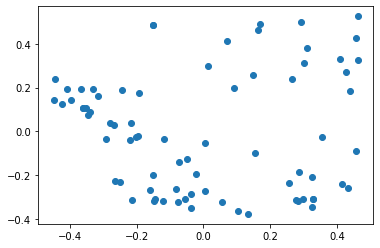

In [37]:
pca = PCA(n_components=2)
x_pca = pca.fit_transform(sentence_embeddings)
explained_variance = pca.explained_variance_ratio_
print("Explained variance = ",sum(explained_variance))
plt.scatter(x = x_pca.T[0], y=x_pca.T[1])
plt.show()

## Clustering

In [38]:
# clustering
from sklearn.cluster import SpectralClustering, AffinityPropagation

In [39]:
# use algorithms to reduce demension

pca = PCA()
sentence_embeddings_distilled = pca.fit_transform(sentence_embeddings)

In [40]:
# concate with sentiment scores
# decided not to use it
# sentence_embeddings_distilled = np.concatenate((sentence_embeddings_distilled, sentiment_probability), axis=1)
sentence_embeddings_distilled.shape

(76, 76)

In [41]:
cluster_algo = AffinityPropagation(random_state=43)
# cluster_algo = SpectralClustering(random_state=43, n_clusters=18)
# cluster = cluster_algo.fit(sentence_embeddings)
cluster = cluster_algo.fit(sentence_embeddings_distilled)
print("Clustered into {} clusters with labels {}".format(
    np.unique(cluster.labels_).shape, np.unique(cluster.labels_)))


Clustered into (15,) clusters with labels [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [42]:
unique, count = np.unique(cluster.labels_, return_counts=True)
print(dict(zip(*np.unique(cluster.labels_, return_counts=True))))


{0: 4, 1: 3, 2: 9, 3: 1, 4: 1, 5: 2, 6: 1, 7: 3, 8: 10, 9: 12, 10: 1, 11: 5, 12: 7, 13: 4, 14: 13}


In [43]:
claim_clusters = {i: [] for i in range(len(np.unique(cluster.labels_)))}
for i,label in enumerate(cluster.labels_):
    claim_clusters[label].append(claims[i])
claim_clusters

{0: ['Yes, you should.',
  'That’s up to you.',
  'go for it',
  'you don’t need to repeat them and learn the hard way'],
 1: ['The “too late” mindset will ruin your investing\n\npsychology and your potential to make enough money to enjoy your life.',
  'It’s not too late to invest',
  'It’s not too late to invest'],
 2: ['Bitcoin is extremely weird',
  'Bill is a cryptocurrency, or a form of digital currency that uses cryptography for security',
  'Bitcoin is like digital gold',
  'There is no official Bitcoin price',
  'One could argue that gold served a physical world well, we now live in a more digital one',
  'Bitcoin is pretty useless. But so is gold.',
  "Forget Bitcoin's intrinsic use, no-one ever cared about gold's either, but as more sophisticated investors buy into Bitcoin, which will spur on others, it will entrench itself as digital gold",
  'One could argue that gold served a physical world well, we now live in a more digital one',
  "Forget Bitcoin's intrinsic use, no-on

In [44]:
claimCenter_polarty = {}
center_claims_relation = {}
print(sentiment_config.id2label)
if 'Yes' in claimCenter_polarty:
    claimCenter_polarty['Yes'] = 'Positive'
for i,term in enumerate(cluster.cluster_centers_indices_):
    center_claims_relation[i] = claims[term]
    print(f"{i}:\t{claims[term]}", end='\t')
    polarity_index = np.argmax(sentiment_probability[term])
    print(sentiment_config.id2label[polarity_index], sentiment_probability[term])
    claimCenter_polarty[claims[term]] = sentiment_config.id2label[polarity_index]


{0: 'Negative', 1: 'Neutral', 2: 'Positive'}
0:	Yes, you should.	Positive [0.07209409 0.3780802  0.5498257 ]
1:	It’s not too late to invest	Neutral [0.10517488 0.5444639  0.35036126]
2:	Bitcoin is like digital gold	Neutral [0.0883989  0.76961875 0.14198233]
3:	It should be used to determine the trend: up, down, neutral	Neutral [0.08346323 0.8221815  0.09435522]
4:	This is massive	Positive [0.28046918 0.14509925 0.57443154]
5:	The significant thing is to do your own research and comprehend the dangers	Neutral [0.25025406 0.5776155  0.17213048]
6:	The simple answer is Yes.	Neutral [0.09290528 0.6657099  0.24138476]
7:	It is almost certainly in a bubble.	Negative [0.67768484 0.28068116 0.04163406]
8:	If you're wondering whether you should invest in Bitcoin, the short answer is yes	Neutral [0.06097716 0.7552609  0.18376198]
9:	Invest in Bitcoin, only if you are okay to loss all.	Neutral [0.12382859 0.6748595  0.20131189]
10:	You can see the gains!	Positive [0.03091607 0.18892287 0.780161  

## Assign center claims

In [45]:
count = 0
for i in json_content['answers']:
    if i:
        for j in i['claim']:
            claim_center = claims[cluster.cluster_centers_indices_[
                cluster.labels_[count]]]
            j['claimCenter'] = claim_center
            j['claimSentiment'] = claimCenter_polarty[claim_center]
            count += 1


In [46]:
claim_center

'Bitcoin is a highly risky investment and not fit for everyone.'

In [47]:
# output_file_path = '../data/v3_70_filled/Should-I-invest-in-Bitcoin_with_labels_v3_70_filled.json'
# output_file_path = '../data/v3_70_filled/Would-you-get-into-a-self-driving-car_v3_70_filled.json'
output_file_path = '../data/v3_70_filled/auto-driving-aligned.json'
output_file_path = '../data/v3_70_filled/bitcoin-invest-aligned.json'
with open(output_file_path, 'w') as f:
    json.dump(json_content, fp=f, indent=4, ensure_ascii=False)


In [48]:
task = "automos driving"
task = "bitcoin investment"
with open(f"../data/newest_data(rolling update)/claim center and statistics/{task}/claim_clusters.json", 'w') as f:
    json.dump(claim_clusters, f, indent=4, ensure_ascii=False)
with open(f'../data/newest_data(rolling update)/claim center and statistics/{task}/stance_count.json', 'w') as f:
    inv_map = {}
    for k, v in claimCenter_polarty.items():
        v = v.lower()
        inv_map[v] = inv_map.get(v, []) + [k]
    json.dump(inv_map,fp=f, indent=4, ensure_ascii=False)
with open(f'../data/newest_data(rolling update)/claim center and statistics/{task}/center_claims_relation.json', 'w') as f:
    json.dump(center_claims_relation, f, indent=4, ensure_ascii=False)
